<a href="https://colab.research.google.com/github/formroller/ML_clone/blob/master/kaggle/HousePrice/HousePrice_Predict(ko)3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.chdir('/content/drive/MyDrive/kaggle/HousePrice')

커널의 순서
1. Import & Data Check
    - 데이터 탐색
    - 이상치 탐색 및 제거
    - 결측 데이터 확인
    - Skewness(비대칭도) 확인

2. EDA
    - 수치형 자료 탐색
    - 범주형 자료 탐색

3. Feature Engineering
    - Log변환
    - 결측값 처리
    - 유의하지 않은 변수 삭제
    - 범주형 자료 수치형으로 변환

4. Modeling & Make Submission
    - Model : XGBoost
    - Submission

# 1.Import & Data Check

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

plt.style.use('seaborn')
sns.set(font_scale=1.5)

import missingno as msno
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
import xgboost

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# 데이터 형태 파악
print(train.shape, test.shape,'\n')

# 명목/수치형 변수 갯수 파악
num_feats=train.dtypes[train.dtypes != 'object'].index
print(f"Number of Numerical features : {len(num_feats)}")

cate_feats=train.dtypes[train.dtypes == 'object'].index
print(f"Number of Categorical features : {len(cate_feats)}")

(1460, 81) (1459, 80) 

Number of Numerical features : 38
Number of Categorical features : 43


In [6]:
# 변수 형태별 변수명 확인
print(train[num_feats].columns)
print(('*'*80))
print(train[cate_feats].columns)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
********************************************************************************
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual'

## 1) 이상치 탐색 및 제거


In [7]:
# IQR(튜키의 방법)을 이용한 함수를 지정해 이상치 탐색 수행
def detect_outlier(df, n, features):
    outlier_indices=[]
    for col in features:
        Q1=np.percentile(df[col],25)
        Q3=np.percentile(df[col],75)
        IQR=Q3-Q1

        outlier_step=1.5*IQR

        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices=Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers

Outliers_to_drop=detect_outlier(train,2, num_feats[:-1])

# 이상치 발견된 행 확인
train.loc[Outliers_to_drop]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
48,49,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,4,5,1920,2008,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,736,736,GasA,...,Y,SBrkr,736,716,0,1452,0,0,2,0,2,3,TA,8,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,102,0,0,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
93,94,190,C (all),60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,6,1910,1998,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,Fa,Mn,Rec,1046,Unf,0,168,1214,GasW,...,N,SBrkr,1260,1031,0,2291,0,1,2,0,4,2,TA,9,Typ,1,Gd,Detchd,1900.0,Unf,2,506,TA,TA,Y,0,0,0,0,99,0,NaN,NaN,NaN,0,11,2007,WD,Normal,133900
125,126,190,RM,60.0,6780,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,2fmCon,1.5Fin,6,8,1935,1982,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Fa,CBlock,TA,TA,Av,GLQ,490,Unf,0,30,520,GasA,...,N,SBrkr,520,0,234,754,1,0,1,0,2,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,53,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,84500
165,166,190,RL,62.0,10106,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,2fmCon,1.5Fin,5,7,1940,1999,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Gd,BrkTil,TA,TA,No,ALQ,351,Rec,181,112,644,GasA,...,Y,SBrkr,808,547,0,1355,1,0,2,0,4,2,TA,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,140,0,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,127500
172,173,160,RL,44.0,5306,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,2Story,7,7,1987,1987,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,Gd,PConc,Gd,Gd,No,GLQ,495,Rec,215,354,1064,GasA,...,Y,SBrkr,1064,703,0,1767,1,0,2,0,2,1,Gd,5,Typ,1,TA,Attchd,1987.0,RFn,2,504,Gd,TA,Y,441,35,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,239000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,1351,90,RL,91.0,11643,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Artery,Norm,Duplex,2Story,5,5,1969,1969,Gable,CompShg,MetalSd,MetalSd,BrkFace,368.0,TA,TA,CBlock,TA,TA,No,LwQ,500,Unf,0,748,1248,GasA,...,Y,SBrkr,1338,1296,0,2634,1,1,2,2,6,2,TA,12,Typ,0,NaN,Detchd,1969.0,Unf,4,968,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal,200000
634,635,90,RL,64.0,6979,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,Duplex,SFoyer,6,5,1980,1980,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,GLQ,1056,Unf,0,0,1056,GasA,...,Y,SBrkr,1056,0,0,1056,2,0,0,0,0,2,TA,4,Typ,0,NaN,Detchd,1980.0,Unf,2,576,TA,TA,Y,264,56,0,0,0,0,NaN,GdPrv,Shed,600,6,2010,WD,Normal,144000
910,911,90,RL,80.0,11600,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Feedr,Norm,Duplex,2Story,5,5,1960,1960,Gable,CompShg,MetalSd,MetalSd,BrkFace,361.0,TA,TA,CBlock,TA,TA,No,Rec,443,Unf,0,662,1105,GasA,...,Y,FuseA,1105,1169,0,2274,0,0,2,0,5,2,TA,12,Typ,0,NaN,Detchd,1960.0,Unf,2,480,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,Normal,154300
1292,1293,70,RM,60.0,6600,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,5,4,1892,1965,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,Stone,TA,TA,

In [8]:
# 이상치를 제거하고 결과 확인 (행이 1338개로 감소.)
train=train.drop(Outliers_to_drop,axis=0).reset_index(drop=True)
train.shape

(1338, 81)

## 2) 결측치 확인

In [9]:
# train 데이터 컬럼별 결측치(%) 확인
for col in train.columns:
    msper='columns : {:>10} \t Percent of NaN value : {:.2f}%'.format(col, 100*(train[col].isnull().sum()/train[col].shape[0]))
    print(msper)

columns :         Id 	 Percent of NaN value : 0.00%
columns : MSSubClass 	 Percent of NaN value : 0.00%
columns :   MSZoning 	 Percent of NaN value : 0.00%
columns : LotFrontage 	 Percent of NaN value : 17.12%
columns :    LotArea 	 Percent of NaN value : 0.00%
columns :     Street 	 Percent of NaN value : 0.00%
columns :      Alley 	 Percent of NaN value : 94.10%
columns :   LotShape 	 Percent of NaN value : 0.00%
columns : LandContour 	 Percent of NaN value : 0.00%
columns :  Utilities 	 Percent of NaN value : 0.00%
columns :  LotConfig 	 Percent of NaN value : 0.00%
columns :  LandSlope 	 Percent of NaN value : 0.00%
columns : Neighborhood 	 Percent of NaN value : 0.00%
columns : Condition1 	 Percent of NaN value : 0.00%
columns : Condition2 	 Percent of NaN value : 0.00%
columns :   BldgType 	 Percent of NaN value : 0.00%
columns : HouseStyle 	 Percent of NaN value : 0.00%
columns : OverallQual 	 Percent of NaN value : 0.00%
columns : OverallCond 	 Percent of NaN value : 0.00%
colu

* train[col].isnull().sum() : 해당 열의 결측치가 몇 개인지 알 수 있다.(True=1 결측치, Fales=0)
* train[col].shape[0] : 해당 열의 차원 (열이 지정되어 있으므로 행의 갯수 출력)
* 100 * (train[col].isnull().sum()/train[col].shape[0] : 컬럼의 결측치(%) 출력

In [10]:
# test 데이터 결측치 확인
for col in test.columns:
    msper='columns : {:>10}\t Percent of NaN value : {:.2f}%'.format(col, 100*(test[col].isnull().sum()/test[col].shape[0]))
    print(msper)

columns :         Id	 Percent of NaN value : 0.00%
columns : MSSubClass	 Percent of NaN value : 0.00%
columns :   MSZoning	 Percent of NaN value : 0.27%
columns : LotFrontage	 Percent of NaN value : 15.56%
columns :    LotArea	 Percent of NaN value : 0.00%
columns :     Street	 Percent of NaN value : 0.00%
columns :      Alley	 Percent of NaN value : 92.67%
columns :   LotShape	 Percent of NaN value : 0.00%
columns : LandContour	 Percent of NaN value : 0.00%
columns :  Utilities	 Percent of NaN value : 0.14%
columns :  LotConfig	 Percent of NaN value : 0.00%
columns :  LandSlope	 Percent of NaN value : 0.00%
columns : Neighborhood	 Percent of NaN value : 0.00%
columns : Condition1	 Percent of NaN value : 0.00%
columns : Condition2	 Percent of NaN value : 0.00%
columns :   BldgType	 Percent of NaN value : 0.00%
columns : HouseStyle	 Percent of NaN value : 0.00%
columns : OverallQual	 Percent of NaN value : 0.00%
columns : OverallCond	 Percent of NaN value : 0.00%
columns :  YearBuilt	 P

train, test 모두 PoolQC 데이터의 결측치가 높다.

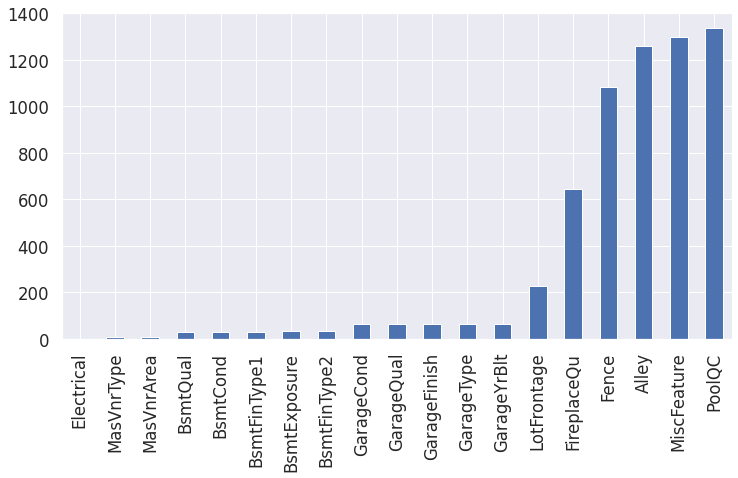

In [11]:
# 결측치 시각화(Bar Plot)
missing=train.isnull().sum()
missing=missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar(figsize=(12,6))

## 3) 비대칭도(Skewness) 확인

In [12]:
for col in num_feats:
    print(f"{col:15} \t Skewness : {train[col].skew():05.2f} \t Kurtosis : {train[col].kurt():06.2f}")

Id              	 Skewness : 00.00 	 Kurtosis : -01.19
MSSubClass      	 Skewness : 01.37 	 Kurtosis : 001.49
LotFrontage     	 Skewness : 01.59 	 Kurtosis : 013.04
LotArea         	 Skewness : 07.78 	 Kurtosis : 123.55
OverallQual     	 Skewness : 00.16 	 Kurtosis : -00.05
OverallCond     	 Skewness : 00.74 	 Kurtosis : 001.23
YearBuilt       	 Skewness : -0.58 	 Kurtosis : -00.60
YearRemodAdd    	 Skewness : -0.52 	 Kurtosis : -01.27
MasVnrArea      	 Skewness : 02.69 	 Kurtosis : 011.04
BsmtFinSF1      	 Skewness : 00.65 	 Kurtosis : -00.50
BsmtFinSF2      	 Skewness : 04.86 	 Kurtosis : 026.86
BsmtUnfSF       	 Skewness : 00.87 	 Kurtosis : 000.29
TotalBsmtSF     	 Skewness : 00.29 	 Kurtosis : 001.17
1stFlrSF        	 Skewness : 00.66 	 Kurtosis : 000.02
2ndFlrSF        	 Skewness : 00.77 	 Kurtosis : -00.80
LowQualFinSF    	 Skewness : 12.74 	 Kurtosis : 170.50
GrLivArea       	 Skewness : 00.66 	 Kurtosis : 000.54
BsmtFullBath    	 Skewness : 00.56 	 Kurtosis : -00.96
BsmtHalfBa

* 수치형 변수의 비대칭도(Skewness)와 첨도(Kurtosis)를 확인한다.
* 이는 분포가 얼마나 비대칭을 띄는가 알려주는 척도이다.

        비대칭도
        - a = 0, 정규분포
        - a < 0, 오른쪽으로 치우침
        - a > 0, 왼쪽으로 치우침

데이터에서 비대칭도와 첨도를 보이는 변수가 여럿 있으며, Target 변수인 **SalePrice**역시 약한 비대칭도를 보인다.

# 2.EDA



## 1) 수치형 변수 탐색

* Correlation Heat Map
* Zoomed Heat Map
* Pair Plot
* Scatter Plot

### a. Correlation Heat Map

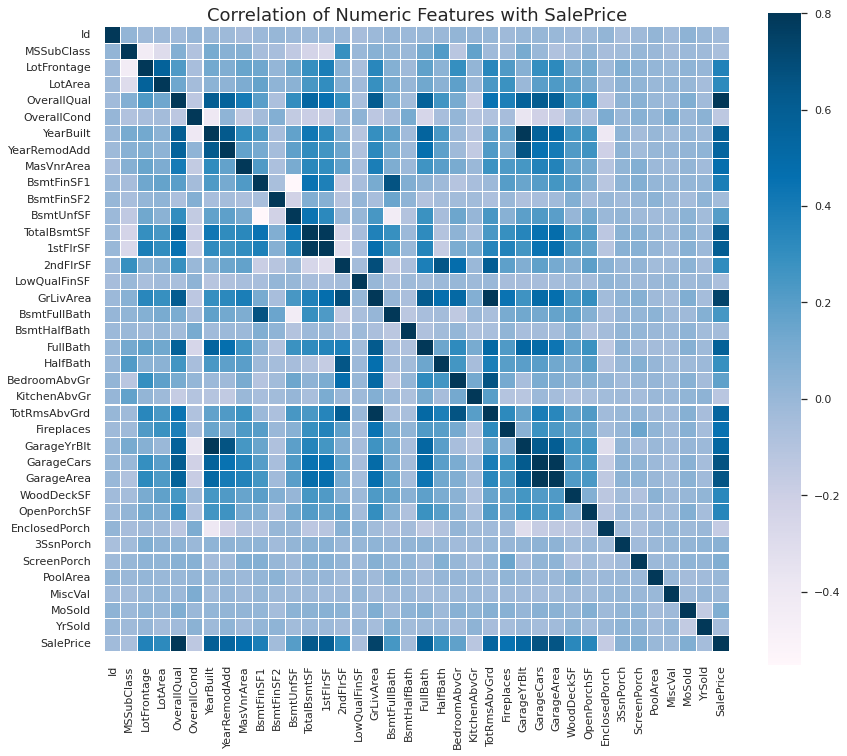

In [13]:
corr_data=train[num_feats]

colormap=plt.cm.PuBu
sns.set(font_scale=1.0)

f,ax=plt.subplots(figsize=(14,12))
plt.title('Correlation of Numeric Features with SalePrice',y=1, size=18)
sns.heatmap(corr_data.corr(), square=True, linewidths=0.1, cmap=colormap, linecolor='white', vmax=.8)

HeatMap은 직관적이며 변수간 상관 관계와 다중 공성선 감지에 유용하다.
1. 대각선 열을 제외한 박스 중 가장 진한 파란색을 띄는 박스가 보이며 이것이 나타내는 것은 다음과 같다.
    * TotalBsmtSF와 1stFlrSF 변수는 상관관계가 있다.  
    * Garage~ 변수들이 서로 상관관계가 있다고 볼 수 있다.   
> 두 경우 모두 변수 사이의 상관 관계가 너무 강한 탓에 다중 공성선(MultiColarisity)이 나타난다고 볼 수 있다.

2. SalePrice와의 상관관계
 * GrLivArea,  TotalBsmtSF, OverallQual과 높은 상관관계를 볼 수 있다.

나머지 변수와의 상관 관계를 자세히 알아보기 위해 Zoomed Heat Map을 확인해본다.


### b.Zoomed Heat Map

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'FullBath', 'TotRmsAbvGrd',
       'YearRemodAdd'],
      dtype='object')


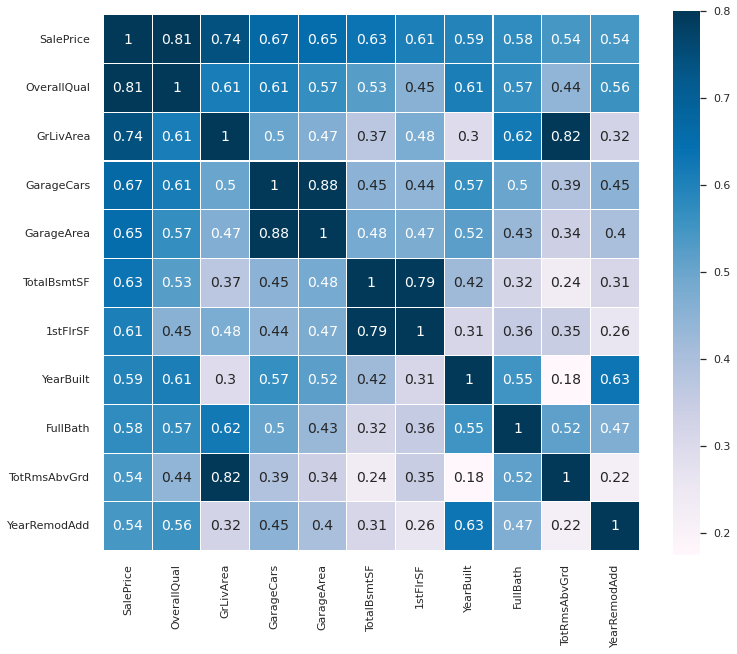

In [14]:
k=11
cols=corr_data.corr().nlargest(k,'SalePrice')['SalePrice'].index
print(cols)
cm=np.corrcoef(train[cols].values.T)
f,ax=plt.subplots(figsize=(12,10))
sns.heatmap(cm,vmax=.8, linewidths=.1, square=True, annot=True, cmap=colormap,
            linecolor='white',xticklabels=cols.values, annot_kws={'size':14}, yticklabels=cols.values)

* 가장 눈에 띄는 GarageCars와 GarageArea, TotalBsmtSF, 1stFlrSF는 서로 밀접하게 연관되어 있다.
* SalePrice와 가장 밀접한 관계가 있는 변수는 OverallQual, GrLivArea, TotalBsmtSF로 보인다.
* GarageCars/GarageArea, TotalBsmtSF/1stFlrSF, TotRmsAbvGrd/GrLivArea 변수들은 유사한 정보를 포함하고 있으므로 다중공성선이 나타난다고 볼 수 있다.
* SalePrice와 더 연관된 변수인 GarageCar와 TotalBsmtSF, GrLivArea는 남기고 나머지 변수는 제거.
* SalePrice와 연관을 더 알아보기 위해 PairPlot을 그려본다.

### c. Pair Plot

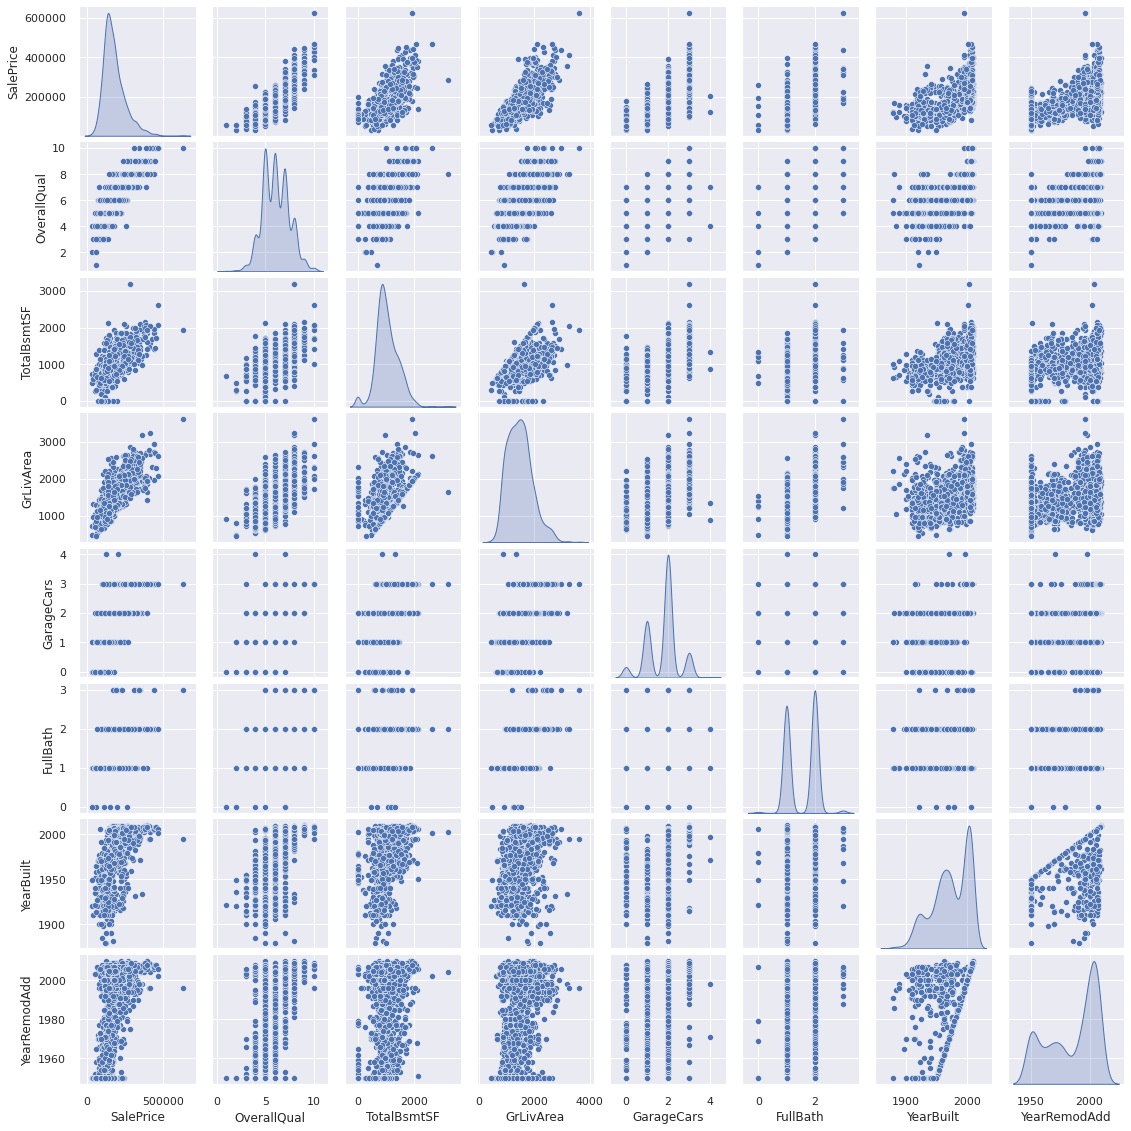

In [15]:
sns.set()
columns=['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageCars','FullBath','YearBuilt','YearRemodAdd']
sns.pairplot(train[columns],size=2, kind='scatter', diag_kind='kde')
plt.show()

* Zoomed Heat Map에서 다중 공선성을 보이는 변수중 SalePrice와 연관이 적은 변수를 제외하고 PairPlot을 그린다.
    * TotalBsmtSF/GrLivArea는 지하실과 생활공간 면적을 의미한다.
    * TotalBsmtSF/GrLivArea의 plot을 보면 점들이 직선처럼 그려지고 대부분의 집은 해당 선 아래에 유지된다.

* SalePrice/YearBuilt의 Plot은 우상향 곡선을 보인다.
    * 이는 전년도 대비 주택 가격 상승의 가속을 의미한다. 

### d.Scatter Plot

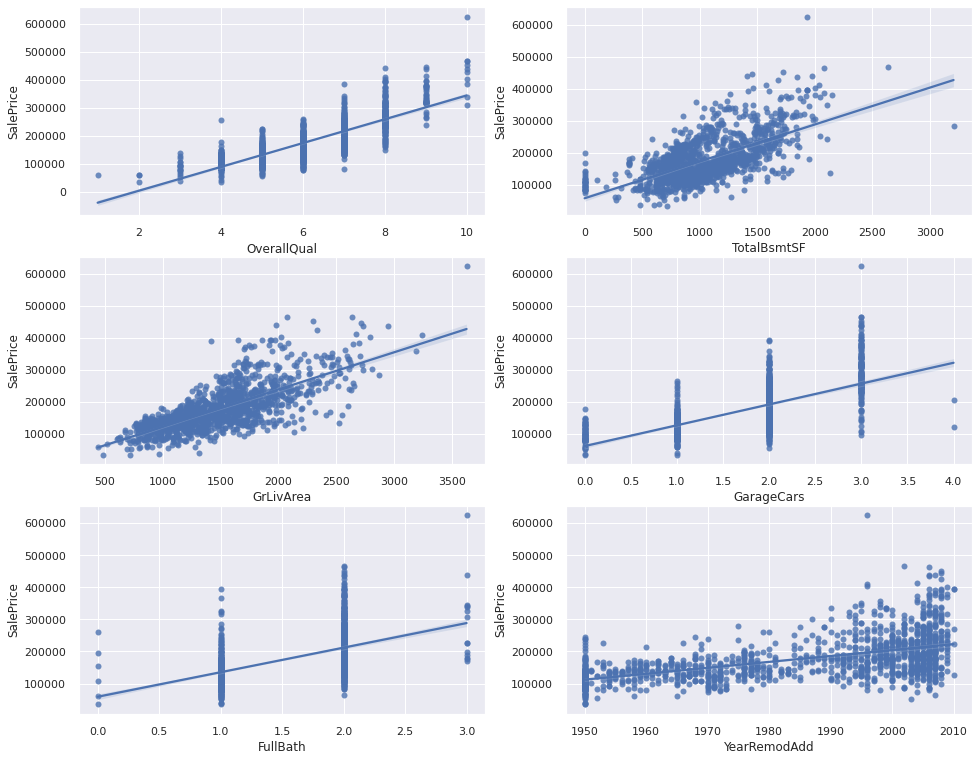

In [16]:
fig, ((ax1,ax2), (ax3,ax4), (ax5,ax6))=plt.subplots(nrows=3, ncols=2, figsize=(16,13))

OverallQual_scatter=pd.concat([train['SalePrice'], train['OverallQual']],axis=1)
sns.regplot(x='OverallQual',y='SalePrice',data=OverallQual_scatter, scatter=True, fit_reg=True, ax=ax1)

TotalBsmtSF_scatter=pd.concat([train['SalePrice'], train['TotalBsmtSF']],axis=1)
sns.regplot(x='TotalBsmtSF',y='SalePrice', data=TotalBsmtSF_scatter, scatter=True, fit_reg=True, ax=ax2)

GrLivArea_scatter=pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
sns.regplot(x='GrLivArea', y='SalePrice', data=GrLivArea_scatter, scatter=True, fit_reg=True, ax=ax3)

GarageCars_scatter=pd.concat([train['SalePrice'], train['GarageCars']], axis=1)
sns.regplot(x='GarageCars', y='SalePrice', data=GarageCars_scatter, scatter=True, fit_reg=True, ax=ax4)

FullBath_scatter=pd.concat([train['SalePrice'], train['FullBath']], axis=1)
sns.regplot(x='FullBath', y='SalePrice', data=FullBath_scatter, scatter=True, fit_reg=True, ax=ax5)

YearRemodAdd_scatter=pd.concat([train['SalePrice'], train['YearRemodAdd']], axis=1)
sns.regplot(x='YearRemodAdd', y='SalePrice', data=YearRemodAdd_scatter, scatter=True, fit_reg=True, ax=ax6)

* SalePrice와 가장 밀접한 연관이 있다고 생각되는 변수들의 산점도를 그린다.
* OverallQual, GarageCars, FulBath 같은 변수들은 범주형 데이터의 특징을 갖는다.(등급, 갯수 등을 의미하기 때문)

## 2) 범주형 변수 탐색
* Violin Plot

질적 변수를 사용해 두 가지 방법을 구현할 수 있다.

 1. 변수 값과 관련해 SalePrice의 분포 확인
 2. 가능한 범주로 더미 변수를 만든다.

In [17]:
for cate in list(cate_feats):
    print(train[cate].value_counts())
    print(('*'*50))

RL         1055
RM          197
FV           65
RH           14
C (all)       7
Name: MSZoning, dtype: int64
**************************************************
Pave    1335
Grvl       3
Name: Street, dtype: int64
**************************************************
Grvl    42
Pave    37
Name: Alley, dtype: int64
**************************************************
Reg    859
IR1    440
IR2     32
IR3      7
Name: LotShape, dtype: int64
**************************************************
Lvl    1211
Bnk      52
HLS      48
Low      27
Name: LandContour, dtype: int64
**************************************************
AllPub    1338
Name: Utilities, dtype: int64
**************************************************
Inside     972
Corner     235
CulDSac     81
FR2         46
FR3          4
Name: LotConfig, dtype: int64
**************************************************
Gtl    1275
Mod      56
Sev       7
Name: LandSlope, dtype: int64
**************************************************
NAmes      20

### 1) Violin Plot

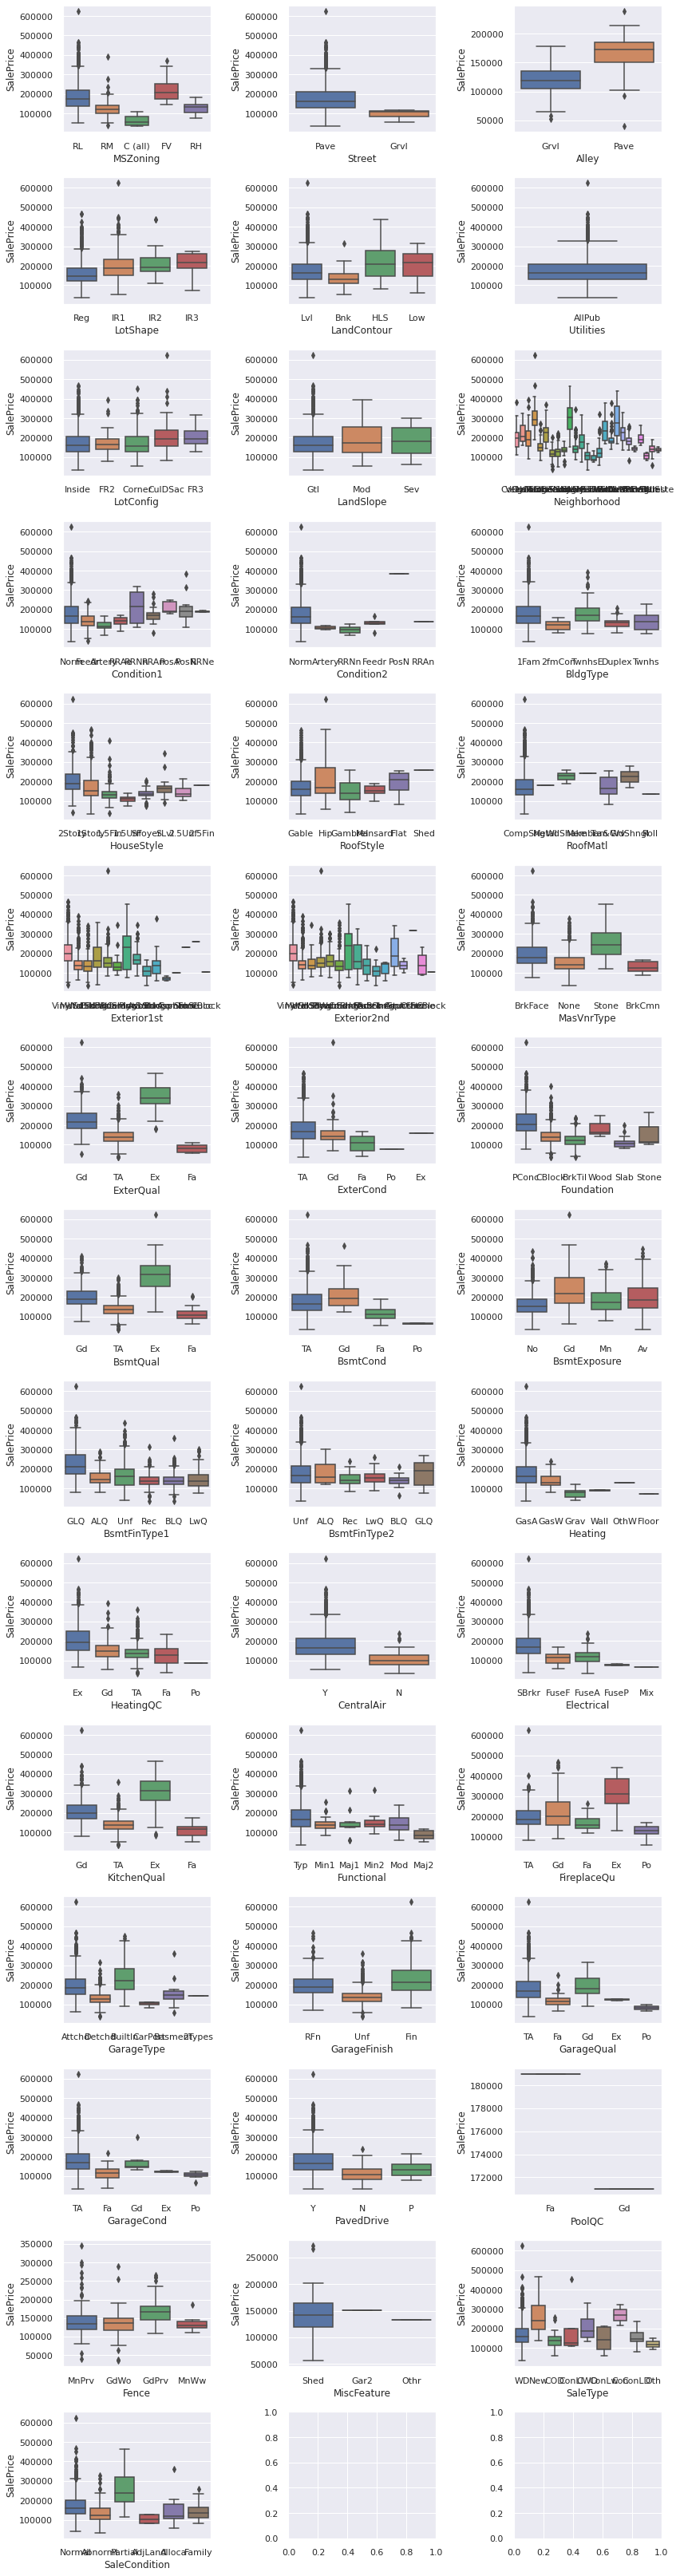

In [18]:
li_cate_feats=list(cate_feats)
nr_rows=15
nr_cols=3

fig,axs=plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4, nr_rows*3))

for r in range(0, nr_rows):
    for c in range(0,nr_cols):
        i=r*nr_cols+c
        if i < len(li_cate_feats):
            sns.boxplot(x=li_cate_feats[i], y=train['SalePrice'],data=train, ax=axs[r][c])
    
plt.tight_layout()
plt.show()

Box Plot을 그려 범주형 변수와 SalePrice의 관계를 확인한다.
 * 일부 범주는 다른 범주보다 SalePrice와 관련해 더 다양하게 보인다.
 * Neighborhood 변수는 주택 가격 편차가 매우 크므로 영향이 큰 것으로 보인다.
 * SaleType 역시 주택 가격 편차가 큼으로 영향이 큰 것으로 보인다. 
 * 수영장이 있으면 가격이 크게 증가한다.


 일부 변수들은 (MSZoning, Neighborhood, Conition2, MasVnrType, ExterQual, BsmtQual, CentralAir, Electircal, KitchenQual, SaleType) SalePrice에 적은 영향을 미친다.

In [19]:
# 편의를 위해 SalePrice와 관련이 큰 변수와 작은 변수를 분리한다.
# Id는 submission을 위해 따로 빼둔다.
num_strong_corr=['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageCars',
                 'FullBath','YearBuilt','YearRemodAdd']

num_weak_corr=['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
                 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF','LowQualFinSF', 'BsmtFullBath',
                 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                 'Fireplaces', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

cate_strong_corr=['MSZoning','Neighborhood','Condition2','MasVnrType', 'ExterQual',
                  'BsmtQual','CentralAir','Electrical','KitchenQual','SaleType']

cate_weak_corr=['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition']

# 3.Feature Engineering

## 1.Log 변환

### 1) 변환 전

Skewness : 1.287364
Kurtosis : 2.555029


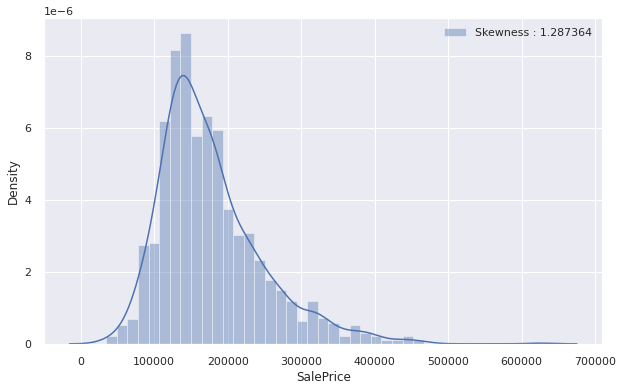

In [20]:
# 변환 전
f, ax=plt.subplots(1,1,figsize=(10,6))
g=sns.distplot(train['SalePrice'], color='b', label='Skewness : {:2f}'.format(train['SalePrice'].skew()), ax=ax)
g=g.legend(loc='best')

print(f"Skewness : {train['SalePrice'].skew():.6f}")
print(f"Kurtosis : {train['SalePrice'].kurt():.6f}")

* SalePrice의 비대칭도와 첨도를 확인한다.
* 그래프와 수치를 확인하면 정상적으로 분포되지 않는 것을 알 수 있다.
* 예측의 정확도를 높히기 위해 로그 변환을 수행한다.

### 2) 변환 후

Skewness : 1.287364
Kurtosis : 2.555029


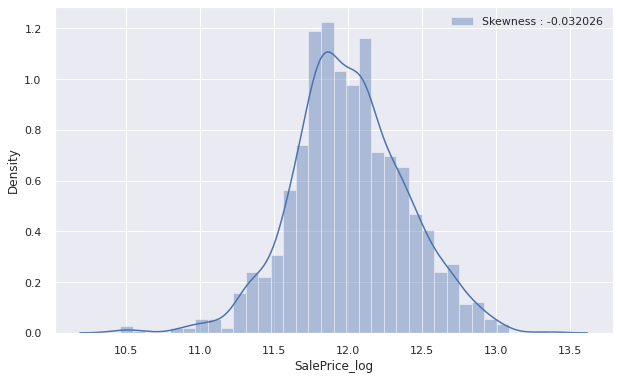

In [21]:
train['SalePrice_log']=train['SalePrice'].map(lambda i : np.log(i) if i > 0 else 0)

f,ax=plt.subplots(1,1,figsize=(10,6))
g=sns.distplot(train['SalePrice_log'], color='b', label='Skewness : {:2f}'.format(train['SalePrice_log'].skew()),ax=ax)
g=g.legend(loc='best')

print(f"Skewness : {train['SalePrice'].skew():.6f}")
print(f"Kurtosis : {train['SalePrice'].kurt():.6f}")

train.drop('SalePrice', axis=1, inplace=True)

* Skewness, Kurtosis를 없애주기 위해 로그를 취한다.
* Log 변환을 SalePrice_log 변수를 만들고 기존의 SalePrcie 변수는 제거한다.
* 로그를 취해준 그래프와 수치가 바뀐 모습을 볼 수 있다. (정규근사화)

Data Check 과정에서 봤을때 왜도와 첨도가 보이는 변수가 여럿 있었다. 그러나 EDA 과정에서 중요하다고 판단된 수치형 변수들은 왜도와 첨도과 보이지 않으므로 SalePrice만 Log를 취해준다.

## 2.결측치 처리
집 값 예측 문제에는 굉장히 많은 결측치(NaN)가 포함되어 있다. 하지만 여러 변수들의 특징을 살펴보면 NaN 의미를 파악할 수 있다.  
결측치(NaN)들은 값의 유무만을 나타낸다. 이렇나 변수들의 특징을 파악해 결측 데이터를 처리하도록 하자.

In [22]:
# '없다' 의미의 값을 갖는 변수이며 이들을 None으로 대체한다.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

for col in cols_fillna:
    train[col].fillna('None', inplace=True)
    test[col].fillna('None',inplace=True)

In [23]:
# 결측치 처리 정도 확인
total=train.isnull().sum().sort_values(ascending=False)
percent=(train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data=pd.concat([total,percent], axis=1, keys=['Total','Percent'])
missing_data.head()

,Total,Percent
LotFrontage,229,0.171151
GarageYrBlt,65,0.048580
MasVnrArea,7,0.005232
SalePrice_log,0,0.000000
ExterCond,0,0.000000


In [24]:
# 나머지 값은 평균값으로 대체한다.
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

# 다시 확인해보면 결측치가 사라진 것을 볼 수 있다.
total=train.isnull().sum().sort_values(ascending=False)
percent=(train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)

missing_data=pd.concat([total,percent], axis=1, keys=['Total','Percent'])
missing_data.head(5)

,Total,Percent
SalePrice_log,0,0.0
Heating,0,0.0
RoofStyle,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0


In [25]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

## 3.유의하지 않은 변수 삭제


In [26]:
# SaelPrice와 상관관계가 약한 모든 변수 삭제
id_test=test['Id']

to_drop_num=num_weak_corr
to_drop_catg=cate_weak_corr

cols_to_drop=['Id']+to_drop_num+to_drop_catg

for df in [train,test]:
    df.drop(cols_to_drop, inplace=True, axis=1)
train.head()

,MSZoning,Neighborhood,Condition2,OverallQual,YearBuilt,YearRemodAdd,MasVnrType,ExterQual,BsmtQual,TotalBsmtSF,CentralAir,Electrical,GrLivArea,FullBath,KitchenQual,GarageCars,SaleType,SalePrice_log
0,RL,CollgCr,Norm,7,2003,2003,BrkFace,Gd,Gd,856,Y,SBrkr,1710,2,Gd,2,WD,12.247694
1,RL,Veenker,Norm,6,1976,1976,None,TA,Gd,1262,Y,SBrkr,1262,2,TA,2,WD,12.109011
2,RL,CollgCr,Norm,7,2001,2002,BrkFace,Gd,Gd,920,Y,SBrkr,1786,2,Gd,2,WD,12.317167
3,RL,Crawfor,Norm,7,1915,1970,None,TA,TA,756,Y,SBrkr,1717,1,Gd,3,WD,11.849398
4,RL,NoRidge,Norm,8,2000,2000,BrkFace,Gd,Gd,1145,Y,SBrkr,2198,2,Gd,3,WD,12.429216


## 4.범주형 변수 수치형으로 변환
EDA의 Box Plot에서 종속변수와 영향이 큰 변수들을 변환한다.

#### 1)Violin Plot

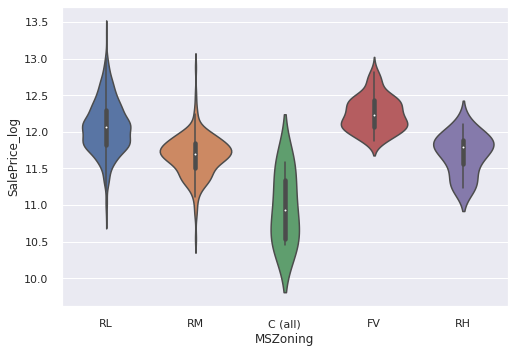

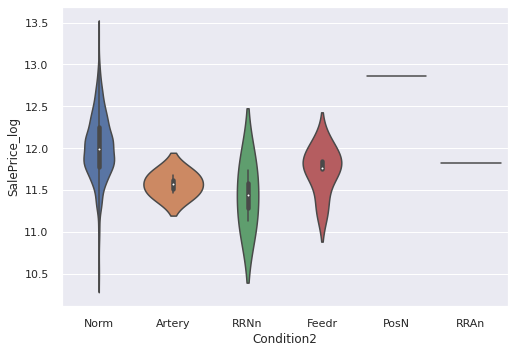

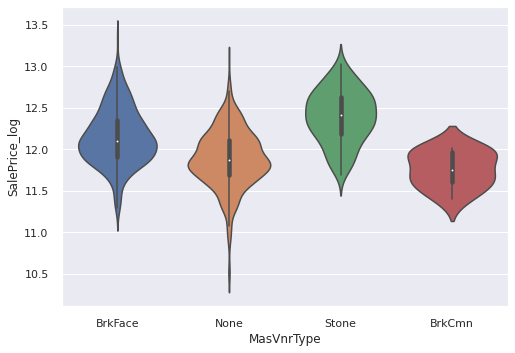

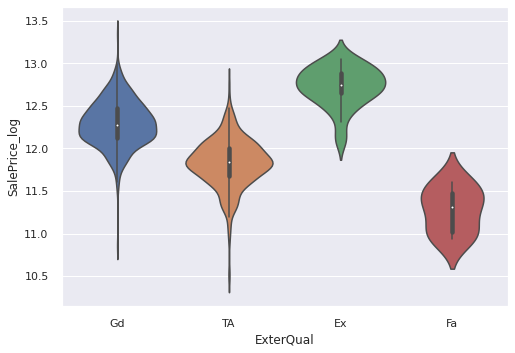

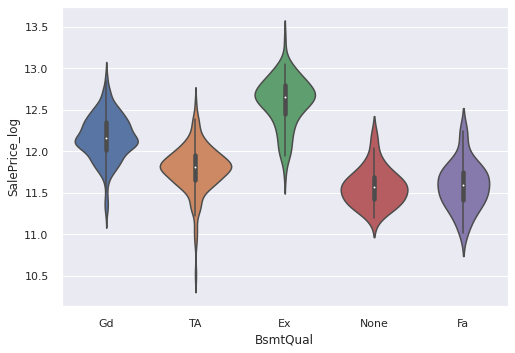

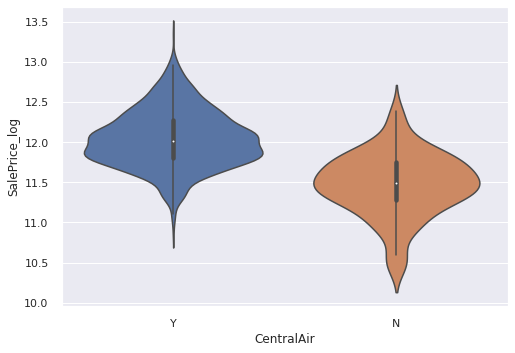

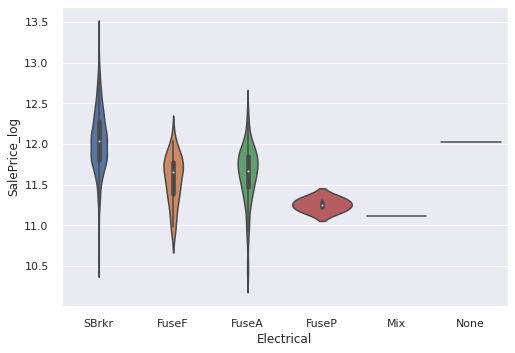

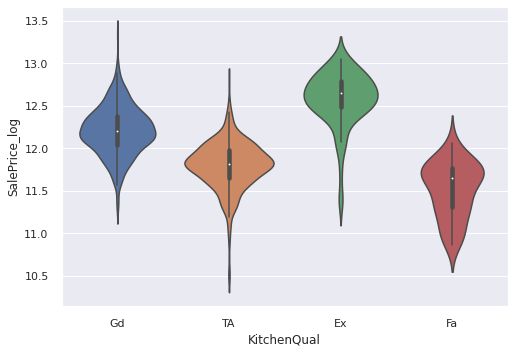

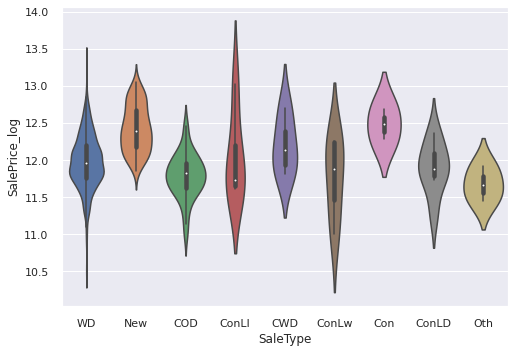

In [27]:
cate_list=cate_strong_corr.copy()
cate_list.remove('Neighborhood')

for cate in cate_list:
    sns.violinplot(x=cate, y=train['SalePrice_log'],data=train)
    plt.show()

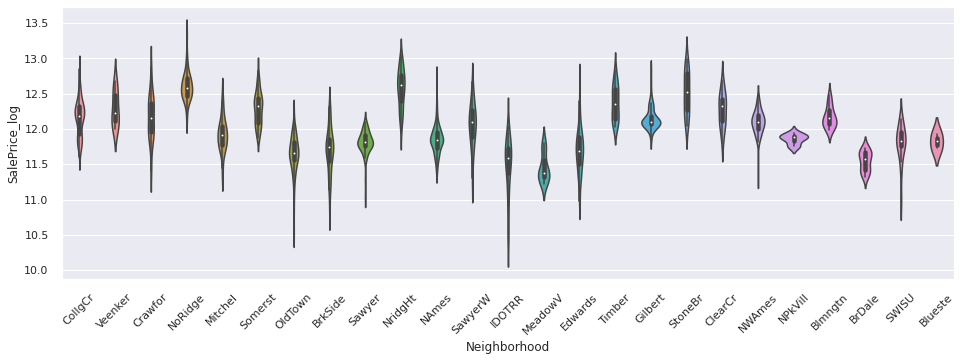

In [28]:
# 범주가 가장 많은 Neighborhood 변수도 확인
fig,ax=plt.subplots()
fig.set_size_inches(16,5)
sns.violinplot(x='Neighborhood', y=train['SalePrice_log'], data=train, ax=ax)
plt.xticks(rotation=45)
plt.show()

In [29]:
for cate in cate_list:
    g=train.groupby(cate)['SalePrice_log'].mean()
    print(g)

MSZoning
C (all)    10.960733
FV         12.246616
RH         11.700602
RL         12.069474
RM         11.677434
Name: SalePrice_log, dtype: float64
Condition2
Artery    11.570036
Feedr     11.734675
Norm      12.012766
PosN      12.860999
RRAn      11.827043
RRNn      11.435329
Name: SalePrice_log, dtype: float64
MasVnrType
BrkCmn     11.757397
BrkFace    12.150038
None       11.884715
Stone      12.391766
Name: SalePrice_log, dtype: float64
ExterQual
Ex    12.727937
Fa    11.274881
Gd    12.295102
TA    11.828332
Name: SalePrice_log, dtype: float64
BsmtQual
Ex      12.595497
Fa      11.585725
Gd      12.170320
None    11.572903
TA      11.791989
Name: SalePrice_log, dtype: float64
CentralAir
N    11.471479
Y    12.042717
Name: SalePrice_log, dtype: float64
Electrical
FuseA    11.641350
FuseF    11.565700
FuseP    11.256345
Mix      11.112448
None     12.028739
SBrkr    12.047595
Name: SalePrice_log, dtype: float64
KitchenQual
Ex    12.582467
Fa    11.514567
Gd    12.209558
TA    11.

In [30]:
# 수치형 변환을 위해 ViolinPlot과 SalePrice_log 평균을 참고해 범주형 변수를 그룹화한다.

# MSZoning
msz_cate2=['RM','RH']
msz_cate3=['RL','FV']

# Neighborhood
nbhd_cate2=['Blmngtn','ClearCr','CollgCr','Crawfor','Gilbert','NWAmes','Somerst','Timber','Veenker']
nbhd_cate3=['NoRidge','NridgHt','StoneBr']

# Condition2
cond2_cate2=['Norm','RRAe']
cond2_cate3=['Posa','PosN']

# SaleType
SlTy_cate1=['Oth']
SlTy_cate3=['CWD']
SlTy_cate4=['New','Con']

In [31]:
# 범주형 변수를 수치형으로 변환
for df in [train, test]:
    df['MSZ_num']=1
    df.loc[(df['MSZoning'].isin(msz_cate2) ), 'MSZ_num']=2 
    df.loc[(df['MSZoning'].isin(msz_cate3) ), 'MSZ_num']=3

    df['nbHd_num']=1
    df.loc[(df['Neighborhood'].isin(nbhd_cate2)),'nbHd_num']=2
    df.loc[(df['Neighborhood'].isin(nbhd_cate3)),'nbHd_num']=3

    df['Cond2_num']=1
    df.loc[(df['Condition2'].isin(cond2_cate2)),'Cond2_num']=2
    df.loc[(df['Condition2'].isin(cond2_cate3)),'Cond2_num']=3

    df['Mas_num']=1
    df.loc[(df['MasVnrType']=='Stone'),'Mas_num']=2
    
    df['ExtQ_num']=1
    df.loc[(df['ExterQual']=='TA'),'ExtQ_num']=2
    df.loc[(df['ExterQual']=='Gd'),'ExtQ_num']=3
    df.loc[(df['ExterQual']=='Ex'),'ExtQ_num']=4

    df['BsQ_num']=1
    df.loc[(df['BsmtQual']=='Gd'), 'BsQ_num']=2
    df.loc[(df['BsmtQual']=='Ex'), 'BsQ_num']=3

    df['CA_num']=0
    df.loc[(df['CentralAir']=='Y'), 'CA_num']=1

    df['Elc_num']=1
    df.loc[(df['Electrical']=='SBrkr'), 'Elc_num']=2

    df['KiQ_num']=1
    df.loc[(df['KitchenQual']=='TA'), 'KiQ_num']=2
    df.loc[(df['KitchenQual']=='Gd'), 'KiQ_num']=3
    df.loc[(df['KitchenQual']=='Ex'), 'KiQ_num']=4

    df['SlTy_num']=2
    df.loc[(df['SaleType'].isin(SlTy_cate1)), 'SlTy_num']=1
    df.loc[(df['SaleType'].isin(SlTy_cate3)), 'SlTy_num']=3
    df.loc[(df['SaleType'].isin(SlTy_cate4)), 'SlTy_num']=4
    df.loc[(df['SaleType'].isin(SlTy_cate4)), 'SlTy_num']=4

### 2)HeatMap

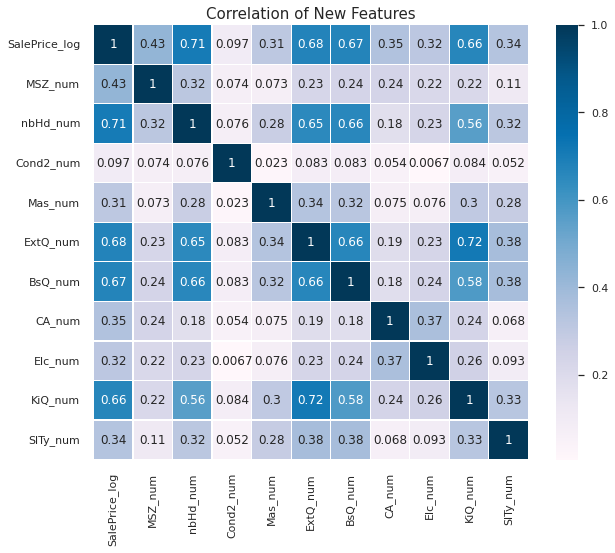

In [32]:
# 수치형으로 변환한 변수들을 HeatMap으로 그려본다. 
# NbHd_num, ExtQ_num, BsQ_num, CA_num, Elc_num, KiQ_num 외 변수는 SalePrice_Log와 큰 상관관계가 없어 보인다.
new_col_HM=train[['SalePrice_log','MSZ_num','nbHd_num','Cond2_num','Mas_num','ExtQ_num',
                  'BsQ_num','CA_num','Elc_num','KiQ_num','SlTy_num']]

colormap=plt.cm.PuBu
plt.figure(figsize=(10,8))
plt.title('Correlation of New Features', y=1.0, size=15)
sns.heatmap(new_col_HM.corr(), linewidths=.2, vmax=1, square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={'size':12})

In [33]:
#  기존 범주형 변수와 새로 만들어진 수치형 변수 역시 유의하지 않은 것들은 사제한다.
train.drop(['MSZoning','Neighborhood','Condition2','MasVnrType','ExterQual','BsmtQual','CentralAir',
            'Electrical','KitchenQual','SaleType','Cond2_num','Mas_num','CA_num','Elc_num','SlTy_num'], axis=1, inplace=True)
test.drop(['MSZoning','Neighborhood','Condition2','MasVnrType','ExterQual','BsmtQual','CentralAir',
            'Electrical','KitchenQual','SaleType','Cond2_num','Mas_num','CA_num','Elc_num','SlTy_num'], axis=1, inplace=True)

train.head() # 완벽히 삭제되어 유의하다고 판단되는 수치형 변수만 남았다.

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FullBath,GarageCars,SalePrice_log,MSZ_num,nbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,7,2003,2003,856,1710,2,2,12.247694,3,2,3,2,3
1,6,1976,1976,1262,1262,2,2,12.109011,3,2,2,2,2
2,7,2001,2002,920,1786,2,2,12.317167,3,2,3,2,3
3,7,1915,1970,756,1717,1,3,11.849398,3,2,2,1,3
4,8,2000,2000,1145,2198,2,3,12.429216,3,3,3,2,3


In [34]:
test.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FullBath,GarageCars,MSZ_num,nbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,5,1961,1961,882.0,896,1,1.0,2,1,2,1,2
1,6,1958,1958,1329.0,1329,1,1.0,3,1,2,1,3
2,5,1997,1998,928.0,1629,2,2.0,3,2,2,2,2
3,6,1998,1998,926.0,1604,2,2.0,3,2,2,1,3
4,8,1992,1992,1280.0,1280,2,2.0,3,3,3,2,3


# 4.Modeling & Make Submission
Model : XGBoost

## 1.Validation

In [35]:
# Test하기전 Validation 과정을 거친다.
X_train=train.drop('SalePrice_log', axis=1).values
y_train=train['SalePrice_log'].values
X_test=test.values

x_tr, x_vld, y_tr, y_vld = train_test_split(X_train, y_train, test_size=.2, random_state=2000)

## 2.Modeling

In [36]:
# XGBoost 모델 생성
regressor=xgboost.XGBRegressor(colsample_bytree=0.4603, learning_rate=0.06, min_child_weight=1.8,
                               max_depth=3, subsample=0.52, n_estimators=2000, random_state=7, nthread=-1)

regressor.fit(x_tr, y_tr)

[04:54:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.4603, learning_rate=0.06, min_child_weight=1.8,
             n_estimators=2000, nthread=-1, random_state=7, subsample=0.52)

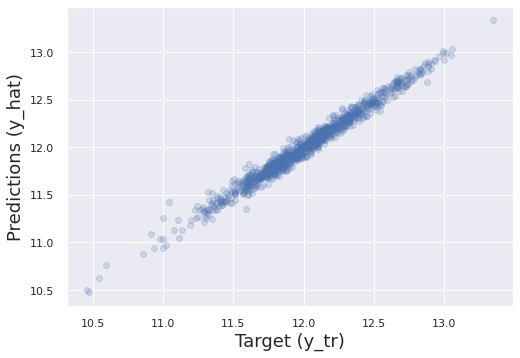

In [37]:
# 예측된 y값(y_hat)에 대한 Scatter Plot을 그려본다.
y_hat=regressor.predict(x_tr)

plt.scatter(y_tr, y_hat, alpha=0.2)
plt.xlabel('Target (y_tr)', size=18)
plt.ylabel('Predictions (y_hat)', size=18)
plt.show()

In [38]:
regressor.score(x_tr, y_tr)

0.9778929954593789

## 3.Predict

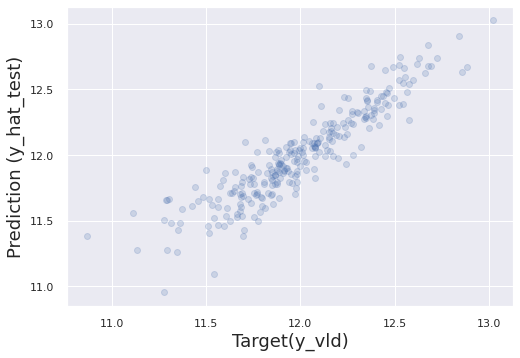

In [39]:
# Validation으로 예측
y_hat_test=regressor.predict(x_vld)

plt.scatter(y_vld, y_hat_test, alpha=0.2)
plt.xlabel('Target(y_vld)', size=18)
plt.ylabel('Prediction (y_hat_test)', size=18)
plt.show()

In [40]:
regressor.score(x_vld, y_vld)

0.8387039163837681

## 4.KFold

In [41]:
accuracy=cross_val_score(estimator=regressor, X=x_tr, y=y_tr, cv=10) #KFold 수행

[04:54:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:54:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:54:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:54:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:54:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:54:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:54:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:54:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [42]:
# 정확도 확인
print(accuracy.mean())
print(accuracy.std())

0.8463773269333027
0.033933803654181784


## 5.Submission

In [44]:
use_logvals=1
pred_xgb=regressor.predict(X_test)

sub_xgb=pd.DataFrame()
sub_xgb['Id']=id_test
sub_xgb['SalePrice']=pred_xgb

if use_logvals==1 :
    sub_xgb['SalePrice']=np.exp(sub_xgb['SalePrice'])



In [46]:
sub_xgb.head()

,Id,SalePrice
0,1461,109063.921875
1,1462,132880.687500
2,1463,182313.062500
3,1464,177576.234375
4,1465,192665.656250


* use_logvals는 Log를 취해준 Target 변수 지수곱을 위해 사용되는 스위치 역할이다.
* 제대로 된 예측을 위해 학습 후 Log변환을 풀어줘야 한다.
